In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

from xgboost import XGBRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Import data (combined SUUMO and geolocation data) 
- Remove some features, e.g. address, stations, etc
- Remove target columns, e.g. deposit, rent, etc
- Split into train and test data. Test is not used until the very end when all testing and optimisation has been completed. 
- Scale features in X for the algorithms that need it.

In [50]:
df = pd.read_csv('/app/data/suumo_geolocation.csv')

print(f"Total unique addresses: {len(df['converted_address'].unique())}")

df.head()

df.drop(["Unnamed: 0",'adress', "converted_address", 'URL', 'ward', 'Line_1', 'Station_1', "Line_2", "Station_2", "Minutes_2", "Line_3", "Station_3", "Minutes_3"], axis=1, inplace=True)

df['Minutes_1'] = df['Minutes_1'].fillna(-1)
# df = pd.get_dummies(df, columns=['Line_1', 'Station_1'], dummy_na=True) # dummy_na=True so will include column for NaN values

df_original = df.copy()

X = df.drop(["rent", "deposit", "key_money", "management_fee"], axis=1)
y_rent = df["rent"]
y_deposit = df["deposit"]
y_key_money = df["key_money"]
y_management_fee = df["management_fee"]

# Perform stratified split
X_train, X_test, y_rent_train, y_rent_test, y_deposit_train, y_deposit_test, y_key_money_train, y_key_money_test, y_management_fee_train, y_management_fee_test = train_test_split(X, y_rent, y_deposit, y_key_money, y_management_fee, test_size=0.2, random_state=42)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale X_train
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale X_test using the fitted transformer from X_train
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Print the scaled DataFrames
X_train_scaled

Total unique addresses: 2941


,Minutes_1,Is_can_access_by_train,Is_can_access_by_bus,Is_can_access_by_car,building_type_apartment,building_type_mansion,building_type_other,is_newly_built,year,no_floors,...,is_specified_good_rental,is_free_rent,is_accessible_by_2_railway_lines,is_accessible_by_3+_railway_lines,is_within_5_minutes_walk_to_station,is_within_10_minutes_walk_to_station,is_top_floor,is_corner_unit,latitude,longitude
0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.020202,0.101695,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.456970,0.696953
1,0.230769,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.030303,0.152542,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.619337,0.239545
2,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.203390,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.606327,0.605517
3,0.230769,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.212121,0.101695,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.261925,0.452873
4,0.230769,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.242424,0.203390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.677882,0.656851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108601,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.323232,0.118644,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.619337,0.239545
108602,0.205128,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.232323,0.016949,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.520931,0.179364
108603,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.090909,0.016949,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.632488,0.236531
108604,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.303030,0.033898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332233,0.283339


## Cluster by longitude and latitude
- Cluster for number of clusters, n, from 1 to 10.
- Use elbow method to select the final n, e.g. the point where Sum of Squared Distances starts to starts to flatten out. A bit arbitrary but I chose 4 as the final n.

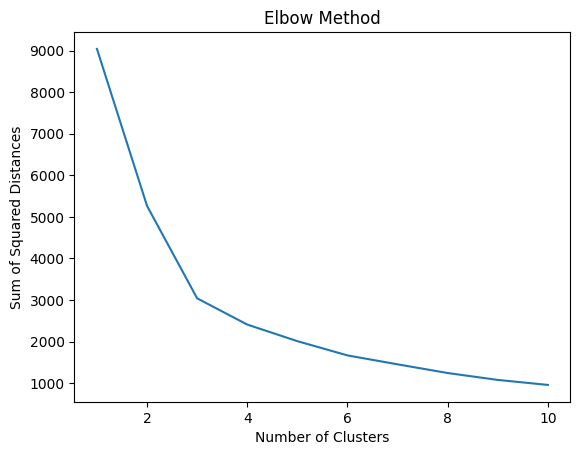

In [42]:
# Create a list to store the sum of squared distances for each number of clusters
sse = []

# Try different numbers of clusters
for k in range(1, 11):
    # Create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Fit the KMeans model to the longitude and latitude data
    kmeans.fit(X_train_scaled[['longitude', 'latitude']])
    
    # Calculate the sum of squared distances for the current number of clusters
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

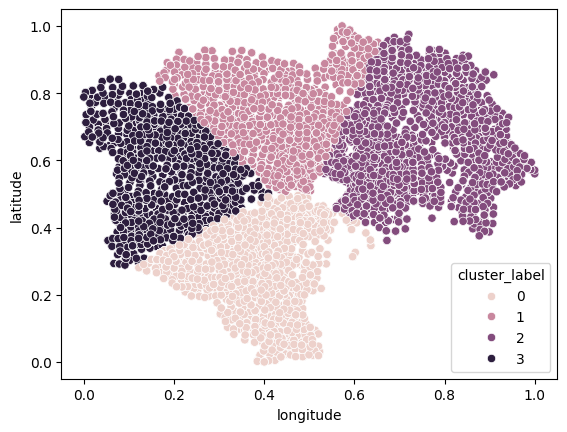

In [28]:
# Create a KMeans instance with n_clusters=3
kmeans = KMeans(n_clusters=4, random_state=0)

# Fit the KMeans model to the longitude and latitude data
kmeans.fit(X_train_scaled[['longitude', 'latitude']])

# Create a new dataframe with latitude, longitude, and cluster label
df_clusters = pd.DataFrame({'longitude': X_train_scaled['longitude'], 'latitude': X_train_scaled['latitude'], 'cluster_label': kmeans.labels_})

# Create a scatter plot of the latitude and longitude with different colors for each cluster
sns.scatterplot(data=df_clusters, x='longitude', y='latitude', hue='cluster_label')

# Display the plot
plt.show()

## Heatmap of rent at each geolocation
- Not very useful, just interested to plot it out.

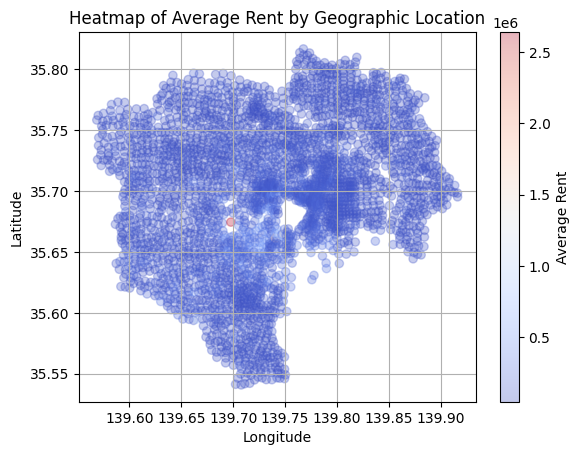

In [19]:
combined_data = pd.concat([X_train[['longitude', 'latitude']], y_rent_train], axis=1)
grouped_data = combined_data.groupby(['longitude', 'latitude']).rent.mean().reset_index()

# Create a scatter plot
sc = plt.scatter(grouped_data['longitude'], grouped_data['latitude'], c=grouped_data['rent'], cmap='coolwarm', alpha=0.3)
plt.colorbar(sc, label='Average Rent')
plt.title('Heatmap of Average Rent by Geographic Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Model selection (original data with outliers)
- Try a bunch of different models using 5-fold cross validation. 
- RandomForestRegressor had the lowest mean absolute error (MAE) but I selected XGBRegressor as it was much much faster than all other models to train.
- As I removed the outliers after this, might be interesting to run with a different metric like mean squared error or R-squared but I haven't done that yet.

In [44]:
# Create a random forest classifier with default parameters
rf_classifier = RandomForestRegressor()

# Cross-validation. Using MAE as the dataset contains significant outliers which MSE and R-squared are sensitive to.
scores = cross_val_score(rf_classifier, X_train_scaled, y_rent_train, cv=5, scoring='neg_mean_absolute_error')

mae_scores = -scores

# Print the mean and standard deviation of the accuracy scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

Mean/std: 9177.12 +/- 484.28


In [22]:
# Create a random forest classifier with default parameters
rf_classifier = XGBRegressor()

# Cross-validation. Using MAE as the dataset contains significant outliers which MSE and R-squared are sensitive to.
scores = cross_val_score(rf_classifier, X_train_scaled, y_rent_train, cv=5, scoring='neg_mean_absolute_error')

mae_scores = -scores

# Print the mean and standard deviation of the accuracy scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

Mean/std: 13682.76 +/- 233.54


In [6]:
# Create an SVR instance with default parameters
lr = LogisticRegression()

# Perform cross-validation with 5 folds and scoring using MAE
scores = cross_val_score(lr, X_train_scaled, y_rent_train, cv=5, scoring='neg_mean_absolute_error')

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

Mean/std: 28795.87 +/- 675.09


In [7]:
# Create an SVR instance with default parameters
gnb = GaussianNB()

# Perform cross-validation with 5 folds and scoring using MAE
scores = cross_val_score(gnb, X_train_scaled, y_rent_train, cv=5, scoring='neg_mean_absolute_error')

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean/std: 76999.92 +/- 4868.53


In [8]:
# Create an SVR instance with default parameters
abr = AdaBoostRegressor()

# Perform cross-validation with 5 folds and scoring using MAE
scores = cross_val_score(abr, X_train_scaled, y_rent_train, cv=5, scoring='neg_mean_absolute_error')

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

Mean/std: 129291.09 +/- 42408.26


## Principal Component Analysis
- The first PCA vector is a linear combination of all features in X that points in the direction with the most variance in the data. The second PCA vector is perpendicular to the first and points in the direction with the second highest variance in the data, etc.
- The rationale is to reduce the number of features, filter out features (by giving them lower weights) that does not provide much meaningful information, and prevent the case where some features maybe highly correlated as the PCA vectors are not linearly correlated. 
- Selected the PCA vectors that added up to account for 90% of the variance in the data (didn't choose 90% for any particular reason other than it accounts for most of the variance).
- Retraining XGBRegressor with the 47 PCA compotnents didn't improve the model, actually made it worse, so we will use the original features.

In [5]:

# PCA transformation
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Choosing the number of components
n_components = np.where(cumulative_variance > 0.90)[0][0] + 1  # for 90% variance

# Applying PCA with selected components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train_scaled)

print(f"Number of components chosen: {n_components}")
print(f"Cumulative variance explained by the chosen components: {cumulative_variance[n_components-1]:.2f}")

Number of components chosen: 47
Cumulative variance explained by the chosen components: 0.90


In [8]:
# Create an XGBRegressor instance with default parameters
xgb_regressor = XGBRegressor()

# Perform cross-validation with 5 folds and scoring using neg_mean_absolute_error
pca_scores = cross_val_score(xgb_regressor, X_pca, y_rent_train, cv=5, scoring="neg_mean_absolute_error")
orig_scores = cross_val_score(xgb_regressor, X_train, y_rent_train, cv=5, scoring="neg_mean_absolute_error")

# Convert the negative MAE scores to positive
mae_scores = -pca_scores
print(f"PCA mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")
mae_scores = -orig_scores
print(f"Original mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

PCA mean/std: 32851.12 +/- 582.74
Original mean/std: 13823.05 +/- 494.52


- Original features are easier for the model to predict with.
## XGBRegressor hyperparam grid search
- Find hyperparameters that reduce the MAE using grid search and cross validation.
- I actually tested 3-4 options for ('n_estimators'  'max_depth', 'min_child_weight': 1, 'subsample', 'colsample_bytree', 'gamma', 'reg_alpha', 'reg_lambda') but only changing n_estimators and max_depth improved the performance. The default for the latter two are 'n_estimators': 100 and 'max_depth': 3 but the best found where 500 (can get better if you go higher but benefit above 500 is minimal) and 12 (not better to go higher).


In [23]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 9, 12],
}

# Create an XGBRegressor instance
xgb_regressor = XGBRegressor()

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_rent_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (MAE):", best_score)
print("")

results = grid_search.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print(f"Parameters: {params} Score: {mean_score:.2f} +/- {std_score:.2f}")

Best Parameters: {'max_depth': 12, 'n_estimators': 500}
Best Score (MAE): 9230.409104041868

Parameters: {'max_depth': 6, 'n_estimators': 100} Score: -13823.05 +/- 494.52
Parameters: {'max_depth': 6, 'n_estimators': 300} Score: -12570.98 +/- 534.82
Parameters: {'max_depth': 6, 'n_estimators': 500} Score: -12038.79 +/- 522.64
Parameters: {'max_depth': 9, 'n_estimators': 100} Score: -10902.76 +/- 464.85
Parameters: {'max_depth': 9, 'n_estimators': 300} Score: -10037.60 +/- 474.22
Parameters: {'max_depth': 9, 'n_estimators': 500} Score: -9781.42 +/- 472.18
Parameters: {'max_depth': 12, 'n_estimators': 100} Score: -9590.82 +/- 588.88
Parameters: {'max_depth': 12, 'n_estimators': 300} Score: -9263.69 +/- 594.03
Parameters: {'max_depth': 12, 'n_estimators': 500} Score: -9230.41 +/- 591.91


## Remove outliers
- Remove samples that fall outside the rent upper and lower bounds
- Improves the MAE from above 9000 to under 6000.

In [51]:
def remove_outliers(df):
    # Calculate Q1 and Q3
    Q1 = df["rent"].quantile(0.25)
    Q3 = df["rent"].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df_no_outliers = df[(df["rent"] >= lower_bound) & (df["rent"] <= upper_bound)]

    # Create a DataFrame with only the outliers
    df_outliers = df[(df["rent"] < lower_bound) | (df["rent"] > upper_bound)]

    return df_no_outliers, df_outliers

df, df_outliers = remove_outliers(df_original)

X = df.drop(["rent", "deposit", "key_money", "management_fee"], axis=1)
y_rent = df["rent"]
y_deposit = df["deposit"]
y_key_money = df["key_money"]
y_management_fee = df["management_fee"]

# Perform stratified split
X_train, X_test, y_rent_train, y_rent_test, y_deposit_train, y_deposit_test, y_key_money_train, y_key_money_test, y_management_fee_train, y_management_fee_test = train_test_split(X, y_rent, y_deposit, y_key_money, y_management_fee, test_size=0.2, random_state=42)


In [33]:
# Define the parameter grid
best_params = {
    'n_estimators': 500,
    'max_depth': 12,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 0.1
}
# Create an XGBRegressor instance with default parameters
xgb_regressor = XGBRegressor(**best_params)

# Perform cross-validation with 5 folds and scoring using neg_mean_absolute_error
scores = cross_val_score(xgb_regressor, X_train, y_rent_train, cv=5, scoring="neg_mean_absolute_error")

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

Mean/std: 5985.94 +/- 62.21


## Recursive feature selection
- Systematically remove the least important features
- Keep the best 10
- Reduces MAE from around 6000 to 5200.

In [34]:
# Create an XGBRegressor instance with the best parameters
xgb_regressor = XGBRegressor(**best_params)

# Create an RFE instance, specifying the estimator and the number of features to select
# Adjust the number of features as needed
rfe = RFE(estimator=xgb_regressor, n_features_to_select=10)

# Fit the RFE to the training data
rfe.fit(X_train, y_rent_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['building_type_apartment', 'building_type_mansion', 'year', 'no_floors',
       'layout_1LDK', 'layout_2LDK', 'layout_4DK', 'area', 'latitude',
       'longitude'],
      dtype='object')


In [35]:

xgb_regressor = XGBRegressor(**best_params)

# Select the features from X_train_scaled_filtered
X_train_selected = X_train[selected_features]

# Perform cross-validation with 5 folds and scoring using neg_mean_absolute_error
scores = cross_val_score(xgb_regressor, X_train_selected, y_rent_train, cv=5, scoring="neg_mean_absolute_error")

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

Mean/std: 5210.30 +/- 67.97


## RFE vs high feature importance
- Compare RFE with just removing features with feature importances less than 0.01
- MAE is similar but a bit higher (5500) when using feature importance > 0.01 only compared to using the top 10 features found using RFE.

In [12]:
# 1. Fit the XGBRegressor model to your training data
xgb_regressor = XGBRegressor(**best_params)
xgb_regressor.fit(X_train, y_rent_train)

# 2. Get the feature importances
feature_importances = xgb_regressor.feature_importances_

# 3. Sort the features by their importance in descending order
features = X_train.columns
importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)
for f, i in importances.items():
    print(f"{f}: {i}")

area: 0.2014838457107544
building_type_apartment: 0.06431395560503006
year: 0.036422327160835266
is_furnished_with_appliances: 0.03458965942263603
has_delivery_box: 0.0319092832505703
latitude: 0.031608980149030685
no_rooms: 0.027744382619857788
longitude: 0.022122235968708992
no_floors: 0.02116170898079872
layout_2LDK: 0.020122095942497253
has_system_kitchen: 0.01931031234562397
layout_1LDK: 0.019068075343966484
layout_3K: 0.018328968435525894
has_private_garden: 0.016307538375258446
layout_4K: 0.01628129556775093
layout_4DK: 0.014992878772318363
is_instrument_ok: 0.01472427137196064
has_basement: 0.014499287120997906
is_office_use_allowed: 0.012667926959693432
has_bathroom_dryer: 0.012217573821544647
has_soundproof_room: 0.011944440193474293
building_type_mansion: 0.011404383927583694
has_elevator: 0.01117490790784359
is_tower_mansion: 0.01082367543131113
is_pet_allowed: 0.010696252807974815
layout_4LDK: 0.009901891462504864
is_renovated: 0.00953724980354309
has_floor_heating: 0.0089

- Remove all feature importances less than 0.01

In [13]:
# 4. Select features that have an importance greater than a specified threshold
threshold = 0.01  # Adjust the threshold as needed
selected_features = importances[importances > threshold].index

# 5. Create a new DataFrame using just the selected features
X_train_high_importance = X_train[selected_features]

# Print the selected features and their importances
print("Selected Features and their Importances:")
print(importances[importances > threshold])

# Now X_train_high_importance contains only the features with importance greater than the threshold

Selected Features and their Importances:
area                            0.201484
building_type_apartment         0.064314
year                            0.036422
is_furnished_with_appliances    0.034590
has_delivery_box                0.031909
latitude                        0.031609
no_rooms                        0.027744
longitude                       0.022122
no_floors                       0.021162
layout_2LDK                     0.020122
has_system_kitchen              0.019310
layout_1LDK                     0.019068
layout_3K                       0.018329
has_private_garden              0.016308
layout_4K                       0.016281
layout_4DK                      0.014993
is_instrument_ok                0.014724
has_basement                    0.014499
is_office_use_allowed           0.012668
has_bathroom_dryer              0.012218
has_soundproof_room             0.011944
building_type_mansion           0.011404
has_elevator                    0.011175
is_tower_mansion

- Retrain with feature importances greater than 0.01.

In [14]:
xgb_regressor = XGBRegressor(**best_params)

# Perform cross-validation with 5 folds and scoring using neg_mean_absolute_error
scores = cross_val_score(xgb_regressor, X_train_high_importance, y_rent_train, cv=5, scoring="neg_mean_absolute_error")

# Convert the negative MAE scores to positive
mae_scores = -scores

# Print the mean and standard deviation of the MAE scores
print(f"Mean/std: {mae_scores.mean():.2f} +/- {mae_scores.std():.2f}")

Mean/std: 5546.07 +/- 36.25


## Train the final model
- Using X_train after removing outliers and only using the top 10 features found using RFE
- Tested the final model using the X_test data that was not previously used.
- MAE similar to the cross validation on the training data (5000).

Mean MAE: 4961.98


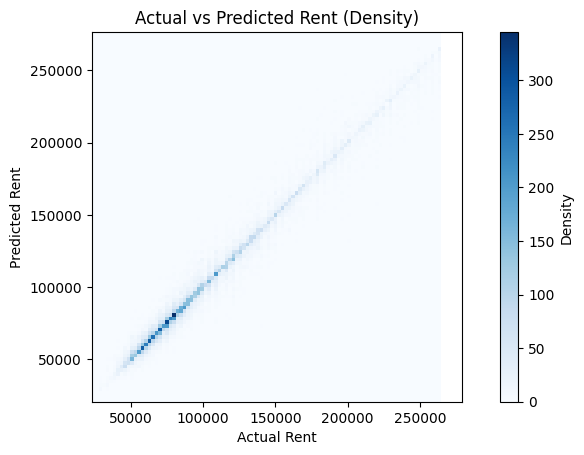

In [55]:
X_test_selected = X_test[selected_features]
X_train_selected = X_train[selected_features]

# Create an instance of the RandomForestRegressor model
model = XGBRegressor(**best_params)

# Train the model using X_train_selected and y_rent_train
model.fit(X_train_selected, y_rent_train)

# Test the model on X_test_selected
predictions = model.predict(X_test_selected)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_rent_test, predictions)

print(f"Mean MAE: {mae:.2f}")

# Plot the predicted values vs the actual y values with density
plt.hist2d(y_rent_test, predictions, bins=100, cmap='Blues')
plt.colorbar(label='Density')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs Predicted Rent (Density)')
plt.axis('square')  # Set the axes to be square
# plt.xlim(0, 2500000)  # Set the x-axis limits
# plt.ylim(0, 2500000)  # Set the y-axis limits
plt.show()